## Accessing and visualizing Sentinel 1 RTC data

### Requirements
#### 1. You can use the following and put it in a yaml file to create a new conda environment with it. 

#### 2. [Temporary because of a [bug in the STAC database](https://github.com/NASA-IMPACT/veda-data-pipelines/issues/313#issuecomment-1473285153)]

- Activate the above environment
- Git clone the [`stackstac` source code repo](https://github.com/gjoseph92/stackstac)
- From the root folder, install the repo as an editable package with `pip` : `pip install -e .`
- Add this line of code above [this line](https://github.com/gjoseph92/stackstac/blob/d53f3dc94e49b95b950201f9e53539a92b1458b6/stackstac/prepare.py#L192):


  ```asset_epsg = int(asset_epsg)```


In [1]:
from stackstac import stack, mosaic
import pystac_client
import matplotlib.pyplot as plt 
import numpy as np

We first create an object to access the STAC test catalog.

In [2]:
URL = "https://stac.test.maap-project.org"
catalog = pystac_client.Client.open(URL)

We select a bounding box of interest to filter items, here around Oslo, and proceed to the catalog query.

In [3]:
bbox = [10.14,59.64,11.37,60.26]

In [4]:
stac_collection = catalog.search(
    collections=["s1-rtc-seasonal-composite"],
    bbox=bbox,
)

We keep only the `vh` polarization, for the purpose of visualization.

In [5]:
stac_items = [i for i in stac_collection.get_all_items() if 'vh' in i.id]

In [6]:
len(stac_items)

2

We hand this over to `stackstac` to create an `xarray.DataArray` object, reproject to 9883 and mosaic along time.

In [7]:
da_dask_array = mosaic(stack(stac_items, epsg=9883 ))

This creates a dask array, the data is not yet loaded in memory

In [8]:
da_dask_array

<xarray.DataArray 'stackstac-37542e040ca16f289e72ca6a6445c2de' (band: 1,
                                                                y: 7185, x: 9066)>
dask.array<mosaic-aggregate, shape=(1, 7185, 9066), dtype=float64, chunksize=(1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates:
  * band       (band) <U11 'cog_default'
  * x          (x) float64 10.4 10.4 10.4 10.4 10.4 ... 15.83 15.83 15.83 15.83
  * y          (y) float64 61.48 61.47 61.47 61.47 ... 59.41 59.41 59.41 59.41
    proj:epsg  float64 3.263e+04
    epsg       int64 9883
Attributes:
    spec:           RasterSpec(epsg=9883, bounds=(10.395242843720034, 59.4098...
    crs:            epsg:9883
    transform:      | 0.00, 0.00, 10.40|\n| 0.00,-0.00, 61.48|\n| 0.00, 0.00,...
    resolution_xy:  (0.0005994949736862765, 0.0002874235080980725)

We now load the data. We can do that because it is a small amount. Note that this line might fail the first time and
and throw a `CPLE_AppDefinedError`, triggered upstream by a time out error. Run it a second time or a third time and it will work -- there is probably a parameter we can pass to increase
the tolerance but I could not find quickly how to do it.

In [10]:
da = da_dask_array.load()

We look at the distribution of the data through a histogram. It is very skewed towards zero, [which is expected for this kind of data](https://hyp3-docs.asf.alaska.edu/guides/rtc_product_guide/#sar-scales), that might come at scales with a couple outlier bright points.

(array([6.5139201e+07, 7.0000000e+00, 1.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 1.0000000e+00]),
 array([  0.        ,  27.39483032,  54.78966064,  82.18449097,
        109.57932129, 136.97415161, 164.36898193, 191.76381226,
        219.15864258, 246.5534729 , 273.94830322]),
 <BarContainer object of 10 artists>)

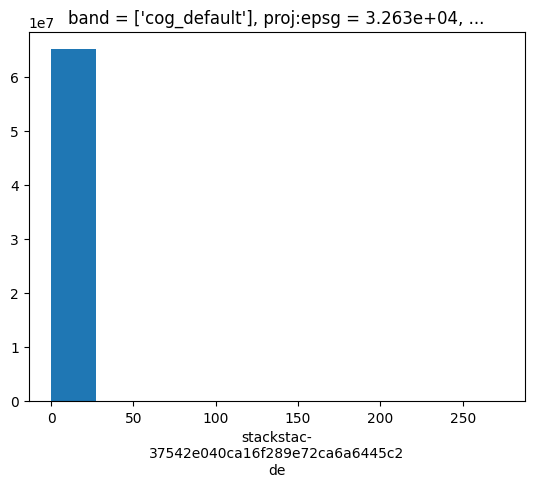

In [11]:
da.plot.hist()

We coarsen that data to increase the speed of the next mapping step. To mitigate the outlier issue, we coarsen it by taking the minimum value over 4x4 pixel boxes. 

In [12]:
coarsened = da.coarsen(x=4, y=4, boundary="trim").min()

(array([2.356863e+06, 1.667632e+06, 4.517300e+04, 4.900000e+01,
        1.100000e+01, 4.000000e+00, 3.000000e+00, 0.000000e+00,
        0.000000e+00, 1.000000e+00]),
 array([0.        , 0.02245311, 0.04490622, 0.06735933, 0.08981244,
        0.11226555, 0.13471866, 0.15717177, 0.17962488, 0.20207799,
        0.2245311 ]),
 <BarContainer object of 10 artists>)

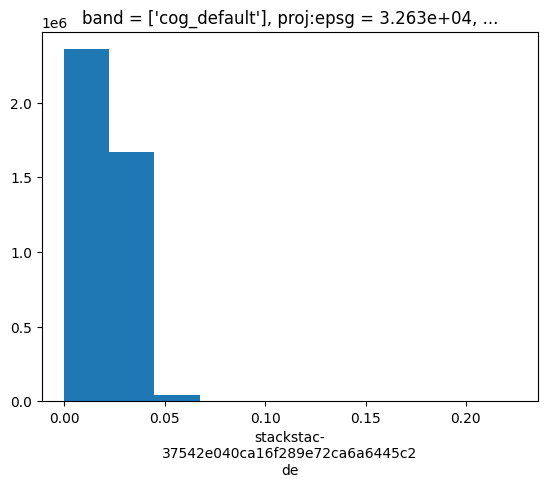

In [13]:
coarsened.plot.hist()

Finally we plot this as a 2D image with a gray color scale.  

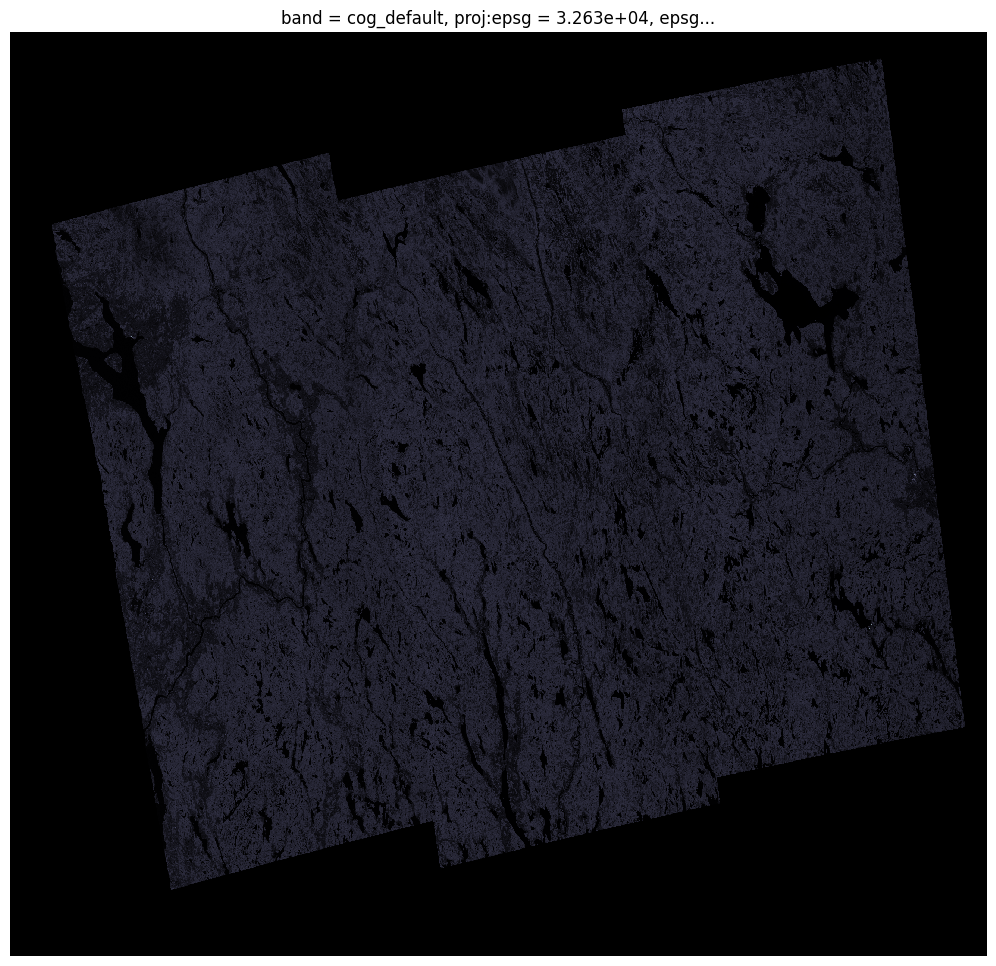

In [14]:
img = (
    coarsened
    .squeeze('band') # this is a singleton dimension, but plot() complains, so we are removing it.
    .plot.imshow(cmap="bone", size=12, aspect=1.05, add_colorbar=False)
)
img.axes.set_axis_off();